In [20]:
import warnings
import gc

import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import SparsePCA, KernelPCA, PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import LeaveOneOut, cross_val_score, KFold

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

plt.style.use('ggplot')
plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = [20, 20]

warnings.simplefilter('ignore')

In [2]:
raw_train = pd.read_csv('./data/train.csv')

In [3]:
raw_train.head()

,ID,target,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,...,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
0,000d6aaf2,38000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
1,000fbd867,600000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
2,0027d6b71,10000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
3,0028cbf45,2000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
4,002a68644,14400000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0


In [4]:
def rmsle(y, y_pred, epislon=1e-20):
    log_error = np.log(y + epislon) - np.log(y_pred + epislon)
    na_mask = np.isnan(log_error)
    print('{0} samples are negative prediction'.format(na_mask.sum()))
    return np.sqrt(np.mean(np.square(log_error[~na_mask]), axis=0))

rmsle_score = make_scorer(rmsle, greater_is_better=False)

In [5]:
def drop_invariant(frame):
    
    drop_variables = []
    categorical = frame.select_dtypes(['object', 'category'])
    continuous = frame.select_dtypes(['number'])
    
    mask = categorical.nunique(axis=0) == 1
    drop_variables.extend(categorical.columns[mask].tolist())
    
    mask = continuous.std(axis=0) == 0
    drop_variables.extend(continuous.columns[mask].tolist())
    
    print('{0} variables dropped.'.format(len(drop_variables)))
    return frame.drop(drop_variables, axis=1)

In [6]:
def sample_feature_importance(meta_estimator):
    sampling_stats = np.vstack([t.feature_importances_
                                for t in meta_estimator.estimators_])

    sample_mean = sampling_stats.mean(axis=0)
    descending_mask = np.argsort(sample_mean)[::-1]

    return sampling_stats, descending_mask

In [7]:
raw_train_1 = drop_invariant(raw_train)

256 variables dropped.


In [28]:
X = raw_train_1[raw_train_1.columns.difference(['target', 'ID'])]
y = raw_train_1['target']

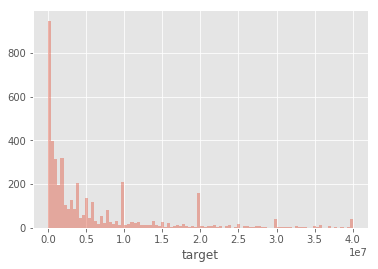

In [9]:
sns.distplot(y, norm_hist=False, kde=False, bins=100)

In [10]:
feat_select = RandomForestRegressor(30)
feat_select.fit(X, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [11]:
sample_means, feat_indice = sample_feature_importance(feat_select)

In [12]:
sorted_feat_importance = sample_means[:, feat_indice].mean(axis=0)

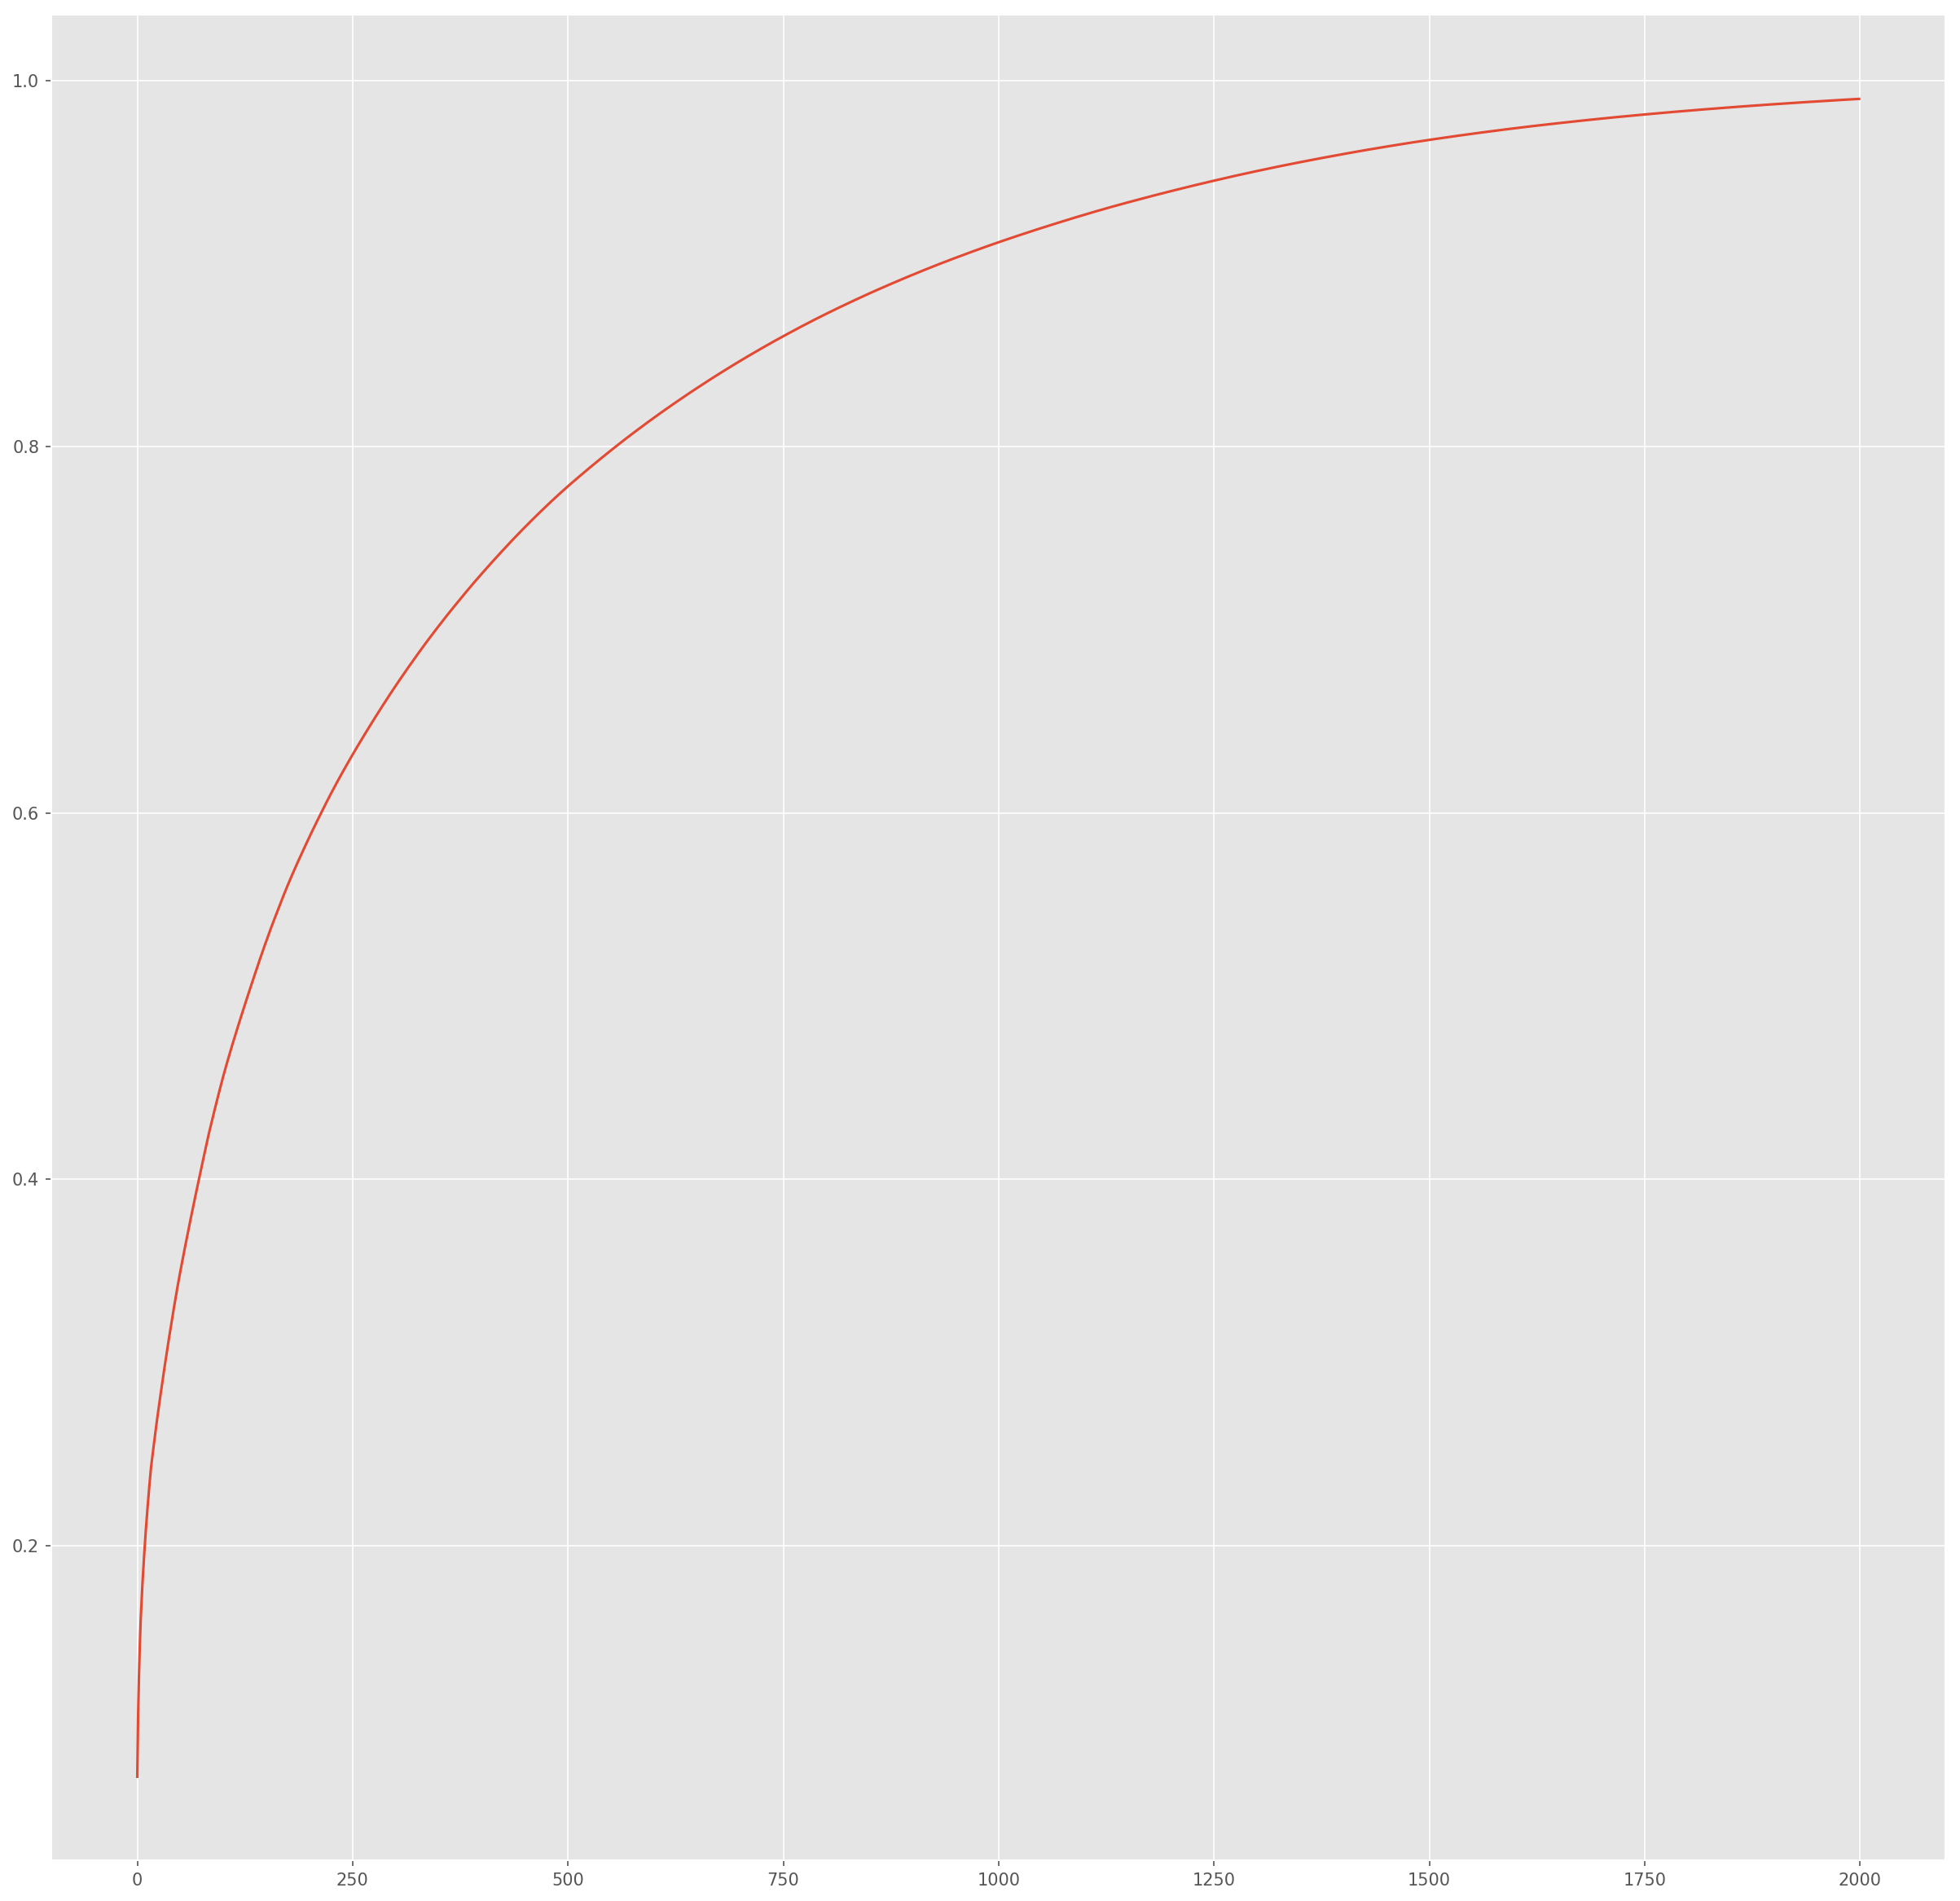

In [25]:
sns.lineplot(data=np.cumsum(sorted_feat_importance)[:2000])

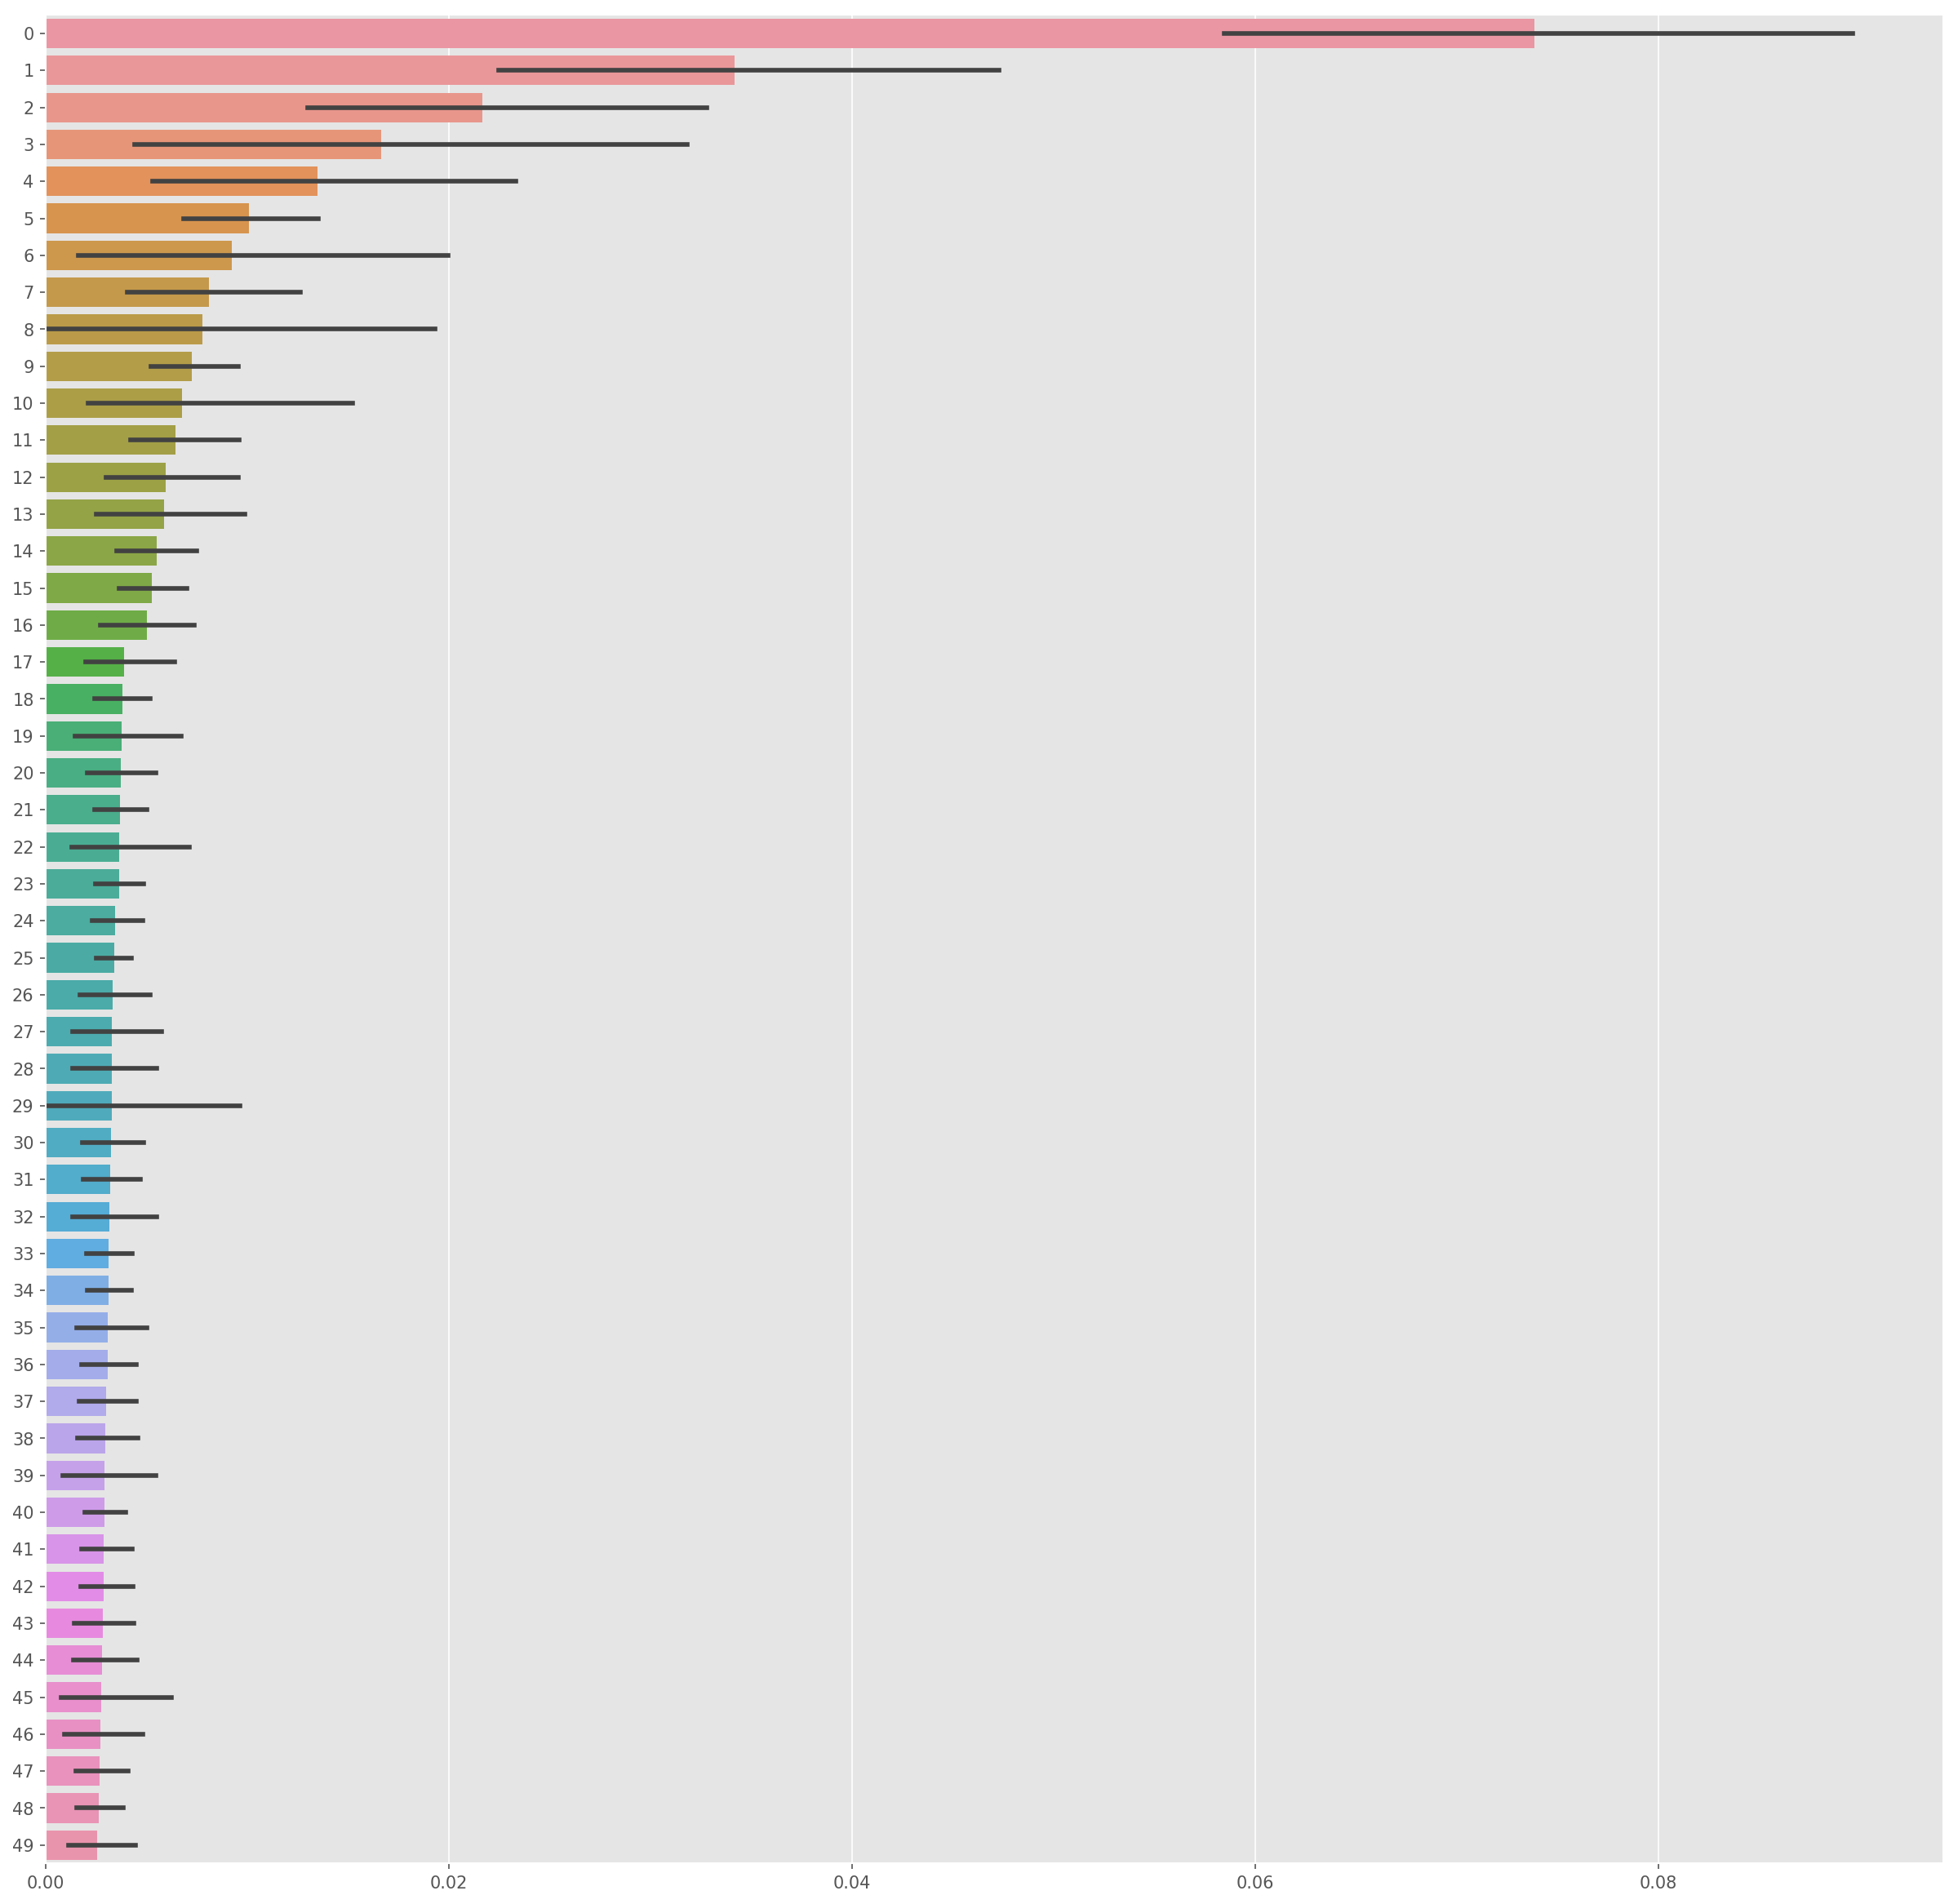

In [22]:
sns.barplot(data=sample_means[:, feat_indice][:, :50], ci=95, orient='h')

In [29]:
X = X.iloc[:, feat_indice[:1500]]

In [32]:
gbt = LGBMRegressor(n_estimators=100)
gbt.fit(X, y)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       learning_rate=0.1, max_depth=-1, min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
       n_jobs=-1, num_leaves=31, objective=None, random_state=None,
       reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=0)

In [33]:
rmsle(gbt.predict(X), y)

139 samples are negative prediction


1.4350974118164594

In [34]:
cv = KFold(5)

In [35]:
cross_val_score(gbt, X, y, scoring=rmsle_score, cv=cv)

26 samples are negative prediction
42 samples are negative prediction
31 samples are negative prediction
32 samples are negative prediction
25 samples are negative prediction


array([-1.67028406, -1.8208026 , -1.69929468, -1.74707227, -1.84594431])

In [39]:
# TODO: why is SPCA so slow?
# pca = SparsePCA(n_components=100)
pca = PCA(n_components=500)
std = StandardScaler()

In [40]:
p = Pipeline([('std', std), ('dim', pca), ('gbt', gbt)])

In [41]:
cross_val_score(p, X, y, scoring=rmsle_score, cv=cv)

1 samples are negative prediction
0 samples are negative prediction
1 samples are negative prediction
1 samples are negative prediction
1 samples are negative prediction


array([-1.71000652, -1.84135188, -1.73266444, -1.80414103, -1.87463557])